In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math

# Exploration

In [3]:
#test = torch.load("/home/max/Studium/Leipzig/Semster6/Math_and_ML/math-ml/output_2025-05-19_11-05.pt")
test = torch.load("/home/julian/dev/math-ml/output_2025-05-16_12-48.pt")

In [4]:
test['prompt3']['top_p_probs']

[tensor([0.4365, 0.1569, 0.1417, 0.0319, 0.0219, 0.0201, 0.0184, 0.0079, 0.0075,
         0.0069, 0.0067, 0.0042, 0.0041, 0.0040, 0.0039, 0.0027, 0.0027, 0.0026,
         0.0023, 0.0022, 0.0022, 0.0019, 0.0019, 0.0017, 0.0017, 0.0017, 0.0017,
         0.0016, 0.0016], dtype=torch.float16),
 tensor([1.5747e-01, 7.4951e-02, 6.8237e-02, 6.3110e-02, 3.9825e-02, 3.2745e-02,
         3.0777e-02, 2.9129e-02, 2.6108e-02, 1.3870e-02, 1.2924e-02, 1.2825e-02,
         1.1147e-02, 1.1055e-02, 7.7782e-03, 7.5989e-03, 6.9199e-03, 6.2027e-03,
         5.7373e-03, 5.5161e-03, 5.3062e-03, 5.1842e-03, 5.0621e-03, 4.6082e-03,
         4.2648e-03, 4.1008e-03, 4.0359e-03, 4.0359e-03, 4.0054e-03, 3.9101e-03,
         3.8509e-03, 3.7041e-03, 3.4256e-03, 3.1433e-03, 3.1185e-03, 3.0231e-03,
         3.0231e-03, 2.8629e-03, 2.7523e-03, 2.7313e-03, 2.6684e-03, 2.6264e-03,
         2.5654e-03, 2.5463e-03, 2.5463e-03, 2.5253e-03, 2.2297e-03, 2.1935e-03,
         2.0294e-03, 1.9665e-03, 1.9665e-03, 1.9369e-03, 1.87

In [5]:
print(len(test))
print(test.keys())
print(len(test.keys()))
print(test['prompt0'].keys())

9
dict_keys(['prompt0', 'prompt1', 'prompt2', 'prompt3', 'prompt4', 'prompt5', 'prompt6', 'prompt7', 'prompt8'])
9
dict_keys(['top_p_tokens', 'top_p_probs', 'top_p_logits', 'generated_tokens', 'entropies', 'cosines', 'prompt', 'correct'])


In [7]:
final_dict = {}
for key in test.keys(): #iterate through all prompts
    sample = test[key]
    full_answer_tokens = sample['decoded_tokens']
    full_answer_string = ''.join(full_answer_tokens)
    print(full_answer_tokens)
    print(full_answer_string)
    #get only the float, which is the only tokens we are interested in
    raw_answer = full_answer_string.replace("\n", "")
    raw_answer = raw_answer.replace(" ", "")
    raw_answer = raw_answer.replace('{"answer":', "")
    raw_answer = raw_answer.replace("}", '')
    raw_answer = raw_answer.strip()
    print(raw_answer)
    #find indices of each char of raw_answer -> find indices of each real answer token #TODO what if there is garbage before json and we find wrong indices, robustness?
    visited = []
    for char in raw_answer:
        print(f"{char=}")
        for i,token in enumerate(full_answer_tokens):
            if char in token:
                if i in visited:
                    continue
                else:
                    print(f"index: {i}")
                    print(f"{token=}")
                    visited.append(i)
    print(f"answer token indices: {visited}")

    #entropy calculation
    full_token_probabilites = sample['top_p_probs']
    answer_token_probabilities = []
    for idx in visited:
        answer_token_probabilities.append(full_token_probabilites[idx])
    print(answer_token_probabilities)

    norm_entropies = []
    for prob_distribution in answer_token_probabilities:
        prob_distribution = prob_distribution.float()  # convert to float32 for stable log
        prob_distribution = prob_distribution / prob_distribution.sum()  # ensure probs sum to 1
        entropy = -torch.sum(prob_distribution * torch.log(prob_distribution + 1e-12))  # raw entropy
        max_entropy = math.log(len(prob_distribution)) if len(prob_distribution) > 1 else 1  # avoid div-by-zero
        norm_entropy = entropy / max_entropy  # normalized entropy ∈ [0, 1]
        norm_entropies.append(norm_entropy.item())
    print(norm_entropies)

    try:
        average_entropy = sum(norm_entropies) / len(norm_entropies)
        print(f"{average_entropy=}")
    except ZeroDivisionError:
        print("ZeroDivisionError")
        continue

    sample['average_entropy_of_answer_tokens'] = average_entropy
    print('-----------------')
    

KeyError: 'decoded_tokens'

In [8]:
for key in test.keys():
    print(test[key]['average_entropy_of_answer_tokens'])

KeyError: 'average_entropy_of_answer_tokens'

In [9]:
correct_entropies = []
not_correct_entropies = []
all_entropies = []
correct = 0
not_correct = 0
buggy_sample = 0
for key in test.keys():
    if test[key]['correct'] == 'true':
        correct +=1
        correct_entropies.append(test[key]['average_entropy_of_answer_tokens'])
    elif test[key]['correct'] == 'false':
        not_correct += 1
        not_correct_entropies.append(test[key]['average_entropy_of_answer_tokens'])
    else:
        buggy_sample += 1
        
    all_entropies.append(test[key]['average_entropy_of_answer_tokens'])

print(f"Correct samples: {correct}")
print(f"Incorrect samples: {not_correct}")
print(f"Accuracy: {correct}/{correct + not_correct}")
try:
    average_entropy_correct = sum(correct_entropies) / len(correct_entropies)
    average_entropy_not_correct = sum(not_correct_entropies) / len(not_correct_entropies)
    average_entropy_all_samples = sum(all_entropies) / len(all_entropies)
    print(f"{average_entropy_correct=}")
    print(f"{average_entropy_not_correct=}")
    print(f"{average_entropy_all_samples=}")
except ZeroDivisionError:
    print("ZeroDivisionError")

print(f"There were {buggy_sample} samples which had an error, hence not considered.") 

KeyError: 'average_entropy_of_answer_tokens'

# Plotting

(800,)
0.38441375732421873


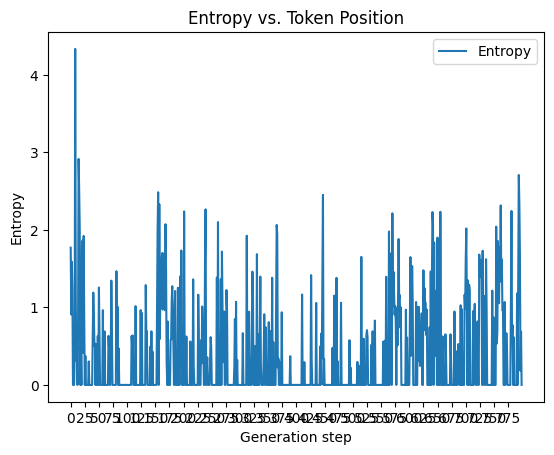

In [8]:
#entropy over tokens for one prompt
entropies_prompt0 = np.array(test['prompt0']['entropies'])
print(entropies_prompt0.shape)
mean_ent_prompt0 = np.mean(entropies_prompt0, axis=0)
print(mean_ent_prompt0)
plt.plot(entropies_prompt0, label='Entropy')
plt.xticks(np.arange(0, len(entropies_prompt0), 25))
plt.xlabel('Generation step')
plt.ylabel('Entropy')
plt.title('Entropy vs. Token Position')
plt.legend()
plt.show()

(800,)
0.6863592529296875


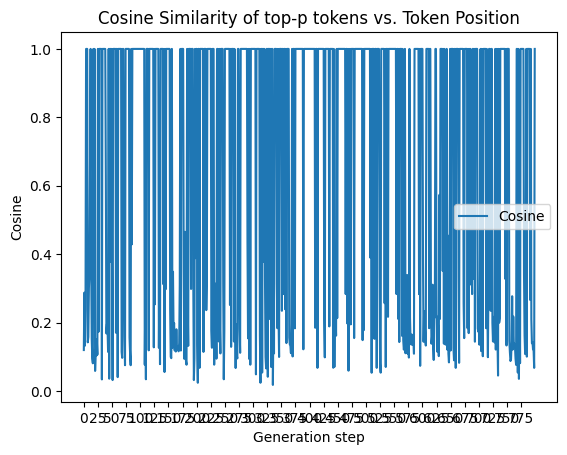

In [39]:
#cosine over tokens for one prompt
cosines_prompt0 = np.array(test['prompt0']['cosines'])
print(cosines_prompt0.shape)
mean_cos_prompt0 = np.mean(cosines_prompt0, axis=0)
print(mean_cos_prompt0)
plt.plot(cosines_prompt0, label='Cosine')
plt.xticks(np.arange(0, len(entropies_prompt0), 25))
plt.xlabel('Generation step')
plt.ylabel('Cosine')
plt.title('Cosine Similarity of top-p tokens vs. Token Position')
plt.legend()
plt.show()

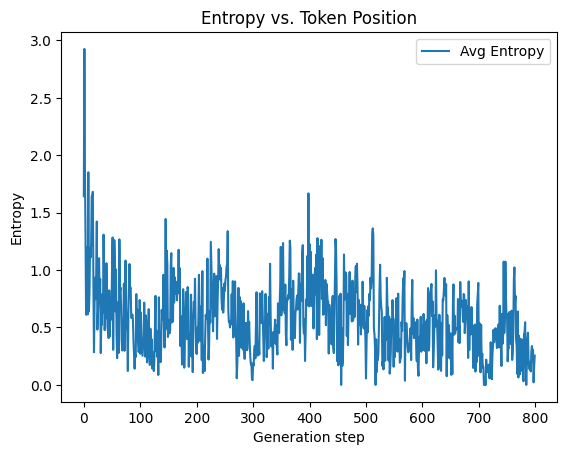

"\n#avg entropy over all prompts\nall_entropies = np.array([res['entropies'] for res in test.values()])  # shape (num_prompts, max_steps)\nprint(all_entropies.shape)\nmean_ent = np.mean(all_entropies, axis=0)\nplt.plot(mean_ent, label='Avg Entropy')\nplt.xlabel('Generation step')\nplt.ylabel('Entropy')\nplt.title('Entropy vs. Token Position')\nplt.legend()\nplt.show()\n"

In [9]:
from itertools import zip_longest
import numpy as np

# Pad shorter sequences with np.nan
all_entropies = [np.array(seq, dtype=float) for seq in [res['entropies'] for res in test.values()]]
max_len = max(len(seq) for seq in all_entropies)
padded = np.array([np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan) for seq in all_entropies])

# Compute mean ignoring NaNs
mean_ent = np.nanmean(padded, axis=0)

# Plot
plt.plot(mean_ent, label='Avg Entropy')
plt.xlabel('Generation step')
plt.ylabel('Entropy')
plt.title('Entropy vs. Token Position')
plt.legend()
plt.show()
# modified this to pad everything to the max token length, otherwise we get error that different 
# prompts have different amount of tokens
'''
#avg entropy over all prompts
all_entropies = np.array([res['entropies'] for res in test.values()])  # shape (num_prompts, max_steps)
print(all_entropies.shape)
mean_ent = np.mean(all_entropies, axis=0)
plt.plot(mean_ent, label='Avg Entropy')
plt.xlabel('Generation step')
plt.ylabel('Entropy')
plt.title('Entropy vs. Token Position')
plt.legend()
plt.show()
'''

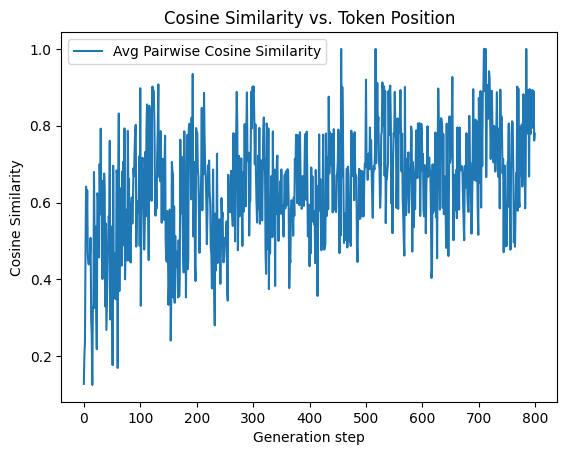

" \n#avg cosine over all prompts\nall_cosines = np.array([res['cosines'] for res in test.values()])  # shape (num_prompts, max_steps)\nprint(all_cosines.shape)\nmean_cos = np.mean(all_cosines, axis=0)\nplt.plot(mean_cos, label='Avg Pairwise Cosine Similarity')\nplt.xlabel('Generation step')\nplt.ylabel('Cosine Similarity')\nplt.title('Cosine Similarity vs. Token Position')\nplt.legend()\nplt.show()\n"

In [10]:
# Pad variable-length cosine sequences with np.nan
all_cosines = [np.array(seq, dtype=float) for seq in [res['cosines'] for res in test.values()]]
max_len = max(len(seq) for seq in all_cosines)
padded_cosines = np.array([np.pad(seq, (0, max_len - len(seq)), constant_values=np.nan) for seq in all_cosines])

# Compute mean ignoring NaNs
mean_cos = np.nanmean(padded_cosines, axis=0)

# Plot
plt.plot(mean_cos, label='Avg Pairwise Cosine Similarity')
plt.xlabel('Generation step')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity vs. Token Position')
plt.legend()
plt.show()
''' 
#avg cosine over all prompts
all_cosines = np.array([res['cosines'] for res in test.values()])  # shape (num_prompts, max_steps)
print(all_cosines.shape)
mean_cos = np.mean(all_cosines, axis=0)
plt.plot(mean_cos, label='Avg Pairwise Cosine Similarity')
plt.xlabel('Generation step')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity vs. Token Position')
plt.legend()
plt.show()
'''

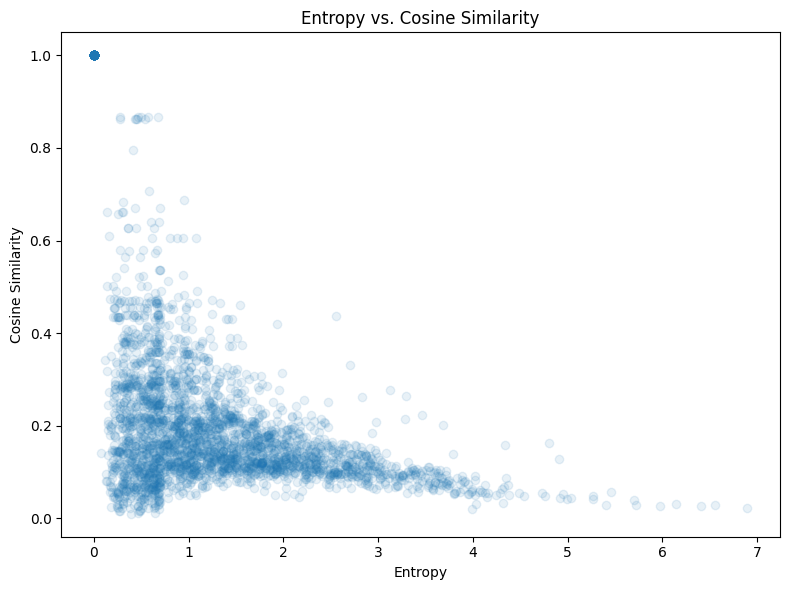

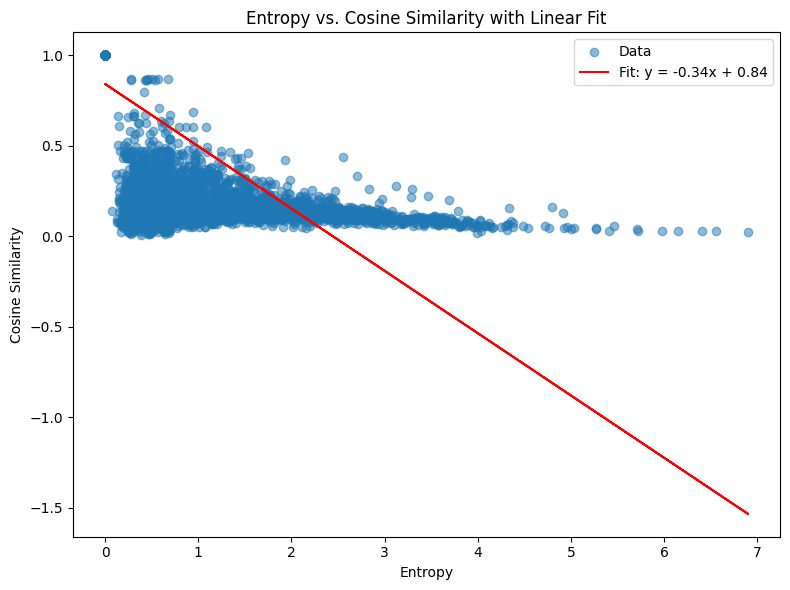

pearson coefficient
-0.7573700310907392
0.0
Spearman coefficient
-0.9311916576452182
0.0


In [11]:
#Entropy vs cosine similarity at token step
entropies = []
cosines = []
for res in test.values():
    entropies.extend(res['entropies'])
    cosines.extend(res['cosines'])

entropies = np.array(entropies, dtype=float)
cosines = np.array(cosines, dtype=float)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(entropies, cosines, alpha=0.1)
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity')
plt.tight_layout()
plt.show()
from scipy.stats import linregress

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(entropies, cosines)
line = slope * entropies + intercept

# Plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(entropies, cosines, alpha=0.5, label='Data')
plt.plot(entropies, line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity with Linear Fit')
plt.legend()
plt.tight_layout()
plt.show()
from scipy.stats import pearsonr
r, p = pearsonr(entropies, cosines)
print("pearson coefficient")
print(r)
print(p)

from scipy.stats import spearmanr
rho, p = spearmanr(entropies, cosines)
print("Spearman coefficient")
print(rho)
print(p)

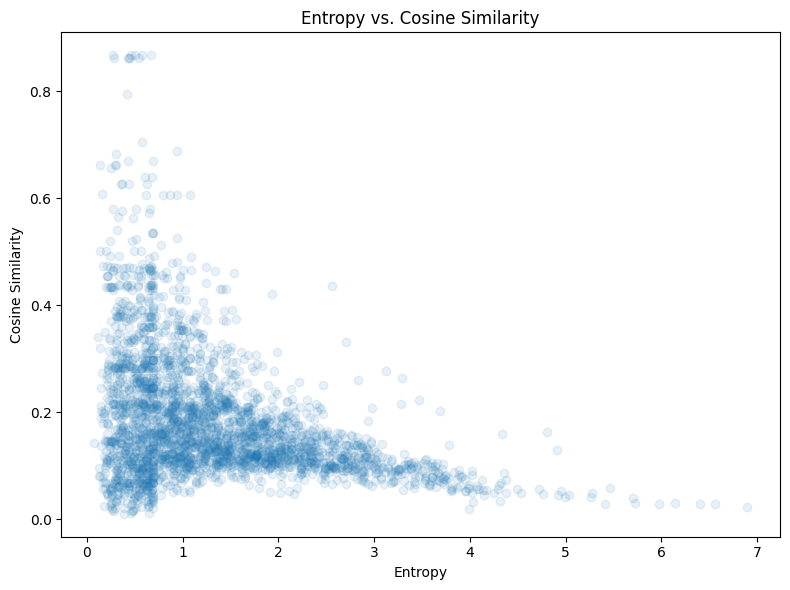

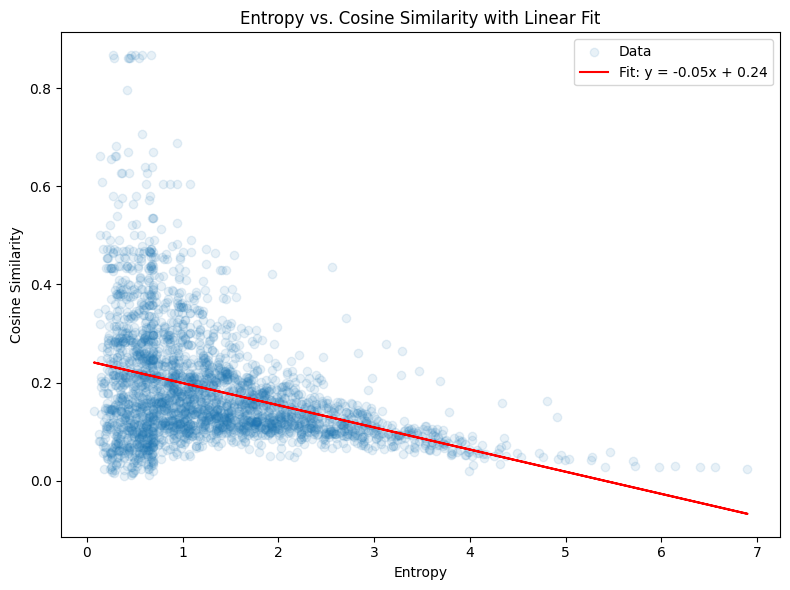

pearson coefficient
-0.36719856800611567
1.2874048452879757e-90
Spearman coefficient
-0.32653493230893593
5.841634213935013e-71


In [12]:
# Remove all pairs where entropy is 0 and cosine is 1
# because maybe that is what is causing the correlation
entropies = np.array(entropies, dtype=float)
cosines = np.array(cosines, dtype=float)

# Create mask for valid pairs
mask = ~((entropies == 0) & (cosines == 1))

# Apply mask
entropies = entropies[mask]
cosines = cosines[mask]


# Rerun experiment
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(entropies, cosines, alpha=0.1)
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity')
plt.tight_layout()
plt.show()
from scipy.stats import linregress

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(entropies, cosines)
line = slope * entropies + intercept

# Plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(entropies, cosines, alpha=0.1, label='Data')
plt.plot(entropies, line, color='red', label=f'Fit: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity with Linear Fit')
plt.legend()
plt.tight_layout()
plt.show()
from scipy.stats import pearsonr
r, p = pearsonr(entropies, cosines)
print("pearson coefficient")
print(r)
print(p)

from scipy.stats import spearmanr
rho, p = spearmanr(entropies, cosines)
print("Spearman coefficient")
print(rho)
print(p)

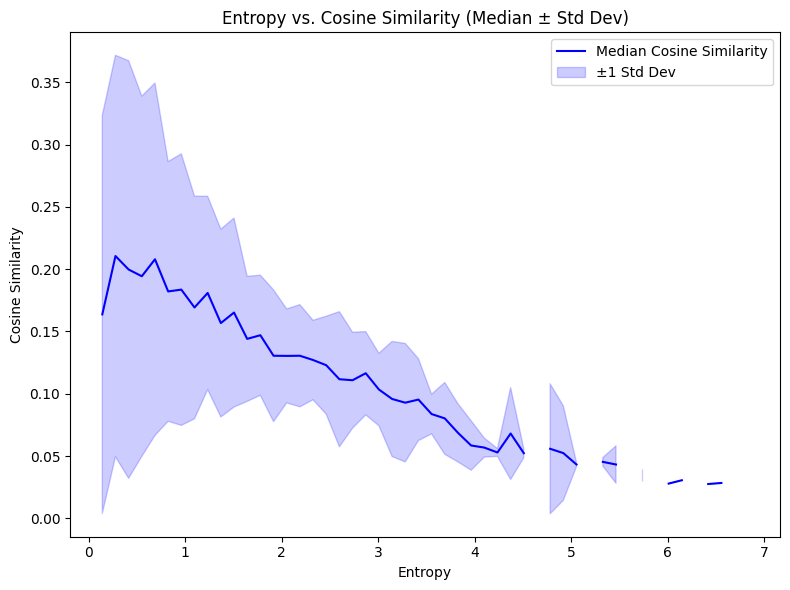

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Assuming entropies and cosines are already numpy arrays
num_bins = 50
bin_means, bin_edges, _ = binned_statistic(entropies, cosines, statistic='mean', bins=num_bins)
bin_medians, _, _ = binned_statistic(entropies, cosines, statistic='median', bins=num_bins)

# Compute standard deviation per bin
bin_indices = np.digitize(entropies, bin_edges)
bin_std = np.zeros(num_bins)
for i in range(1, num_bins + 1):
    bin_values = cosines[bin_indices == i]
    if len(bin_values) > 0:
        bin_std[i-1] = np.std(bin_values)

# Bin centers for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot
plt.figure(figsize=(8, 6))
plt.plot(bin_centers, bin_medians, label='Median Cosine Similarity', color='blue')
plt.fill_between(bin_centers,
                 bin_medians - bin_std,
                 bin_medians + bin_std,
                 color='blue',
                 alpha=0.2,
                 label='±1 Std Dev')
plt.xlabel('Entropy')
plt.ylabel('Cosine Similarity')
plt.title('Entropy vs. Cosine Similarity (Median ± Std Dev)')
plt.legend()
plt.tight_layout()
plt.show()


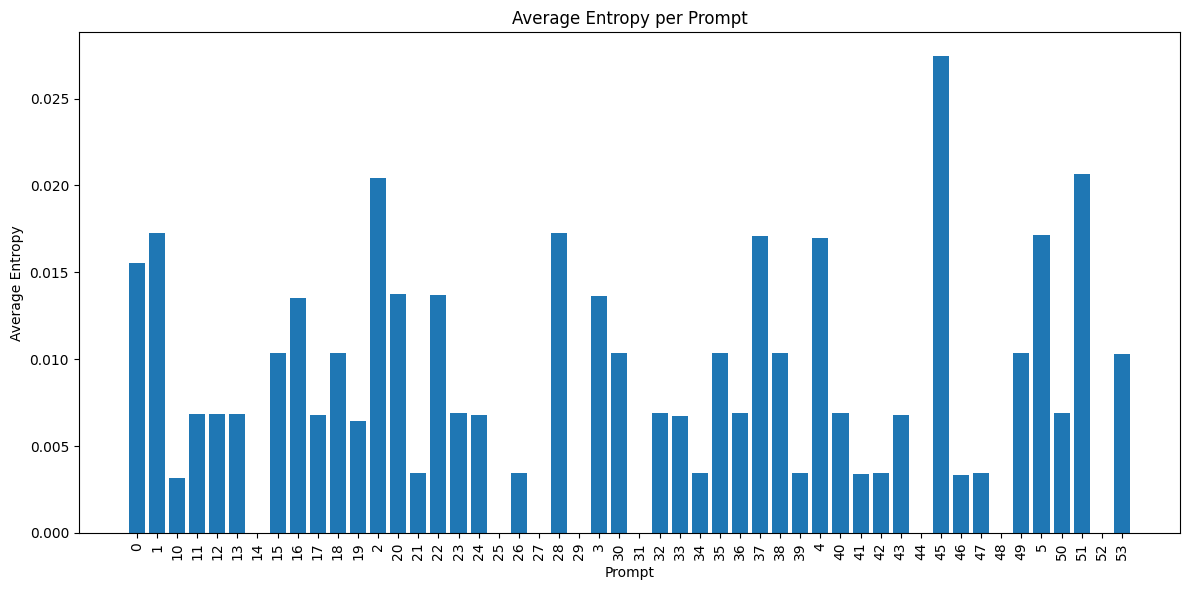

In [ ]:
#maybe uselful for comparing reasoning vs no reasoning (show a small slice of prompts e.g. 50)
slice = 50
prompt_keys = sorted(test.keys())
prompt_keys = prompt_keys[:slice]
avg_entropies = [np.mean(test[k]['entropies']) for k in prompt_keys]
prompt_keys = [key.replace('prompt', '') for key in prompt_keys]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(prompt_keys, avg_entropies)
plt.xlabel('Prompt')
plt.ylabel('Average Entropy')
plt.title('Average Entropy per Prompt')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()